In [76]:
import torch
from numpy import genfromtxt
data = genfromtxt('C:/HKU/Self learning/Machine Learning/ex2/ex2data1.txt', delimiter=',')
data = torch.from_numpy(data)
data = data.chunk(3,1)
norm1 = (data[0]-torch.mean(data[0]))/torch.pow(torch.var(data[0]),0.5)
norm2 = (data[1]-torch.mean(data[1]))/torch.pow(torch.var(data[1]),0.5)
inputs = torch.cat((norm1,norm2),1).float()
targets = data[2].float()

In [77]:
from torch.utils.data import TensorDataset
train_ds = TensorDataset(inputs,targets)

from torch.utils.data import DataLoader
# Define data loader
batch_size = 100
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(train_ds, batch_size)

In [65]:
import torch.nn as nn
import torch.nn.functional as F
class Mymodel(nn.Module):
    def __init__(self,input_size,num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size,num_classes)
    def train_step(self,batch):
        inputs,targets = batch
        outputs = self.linear(inputs)
        targets = targets.squeeze(1).long()
        #sigmoid = 1/(1+torch.exp(-outputs*0.01))
        #loss = torch.sum(-torch.mul(targets, torch.log(sigmoid))-torch.mul(1-targets,torch.log(1-sigmoid)))
        loss = F.cross_entropy(outputs, targets) # Calculate loss
        return loss
    def validation_step(self, batch):
        inputs, targets = batch 
        out = self.linear(inputs)              # Generate predictions
        targets = targets.squeeze(1).long()
        loss = F.cross_entropy(out, targets)   # Calculate loss
        #acc = accuracy(out, targets)           # Calculate accuracy
        _, preds = torch.max(out,dim=1)
        acc = torch.sum(preds==targets)/len(preds)
        return {'val_loss': loss, 'val_acc': acc}

In [90]:
def fit(epoches,train_dl,model,loss_fn,opt):
    for epoch in range(epoches):
        for x,y in train_dl:
            loss = loss_fn(model(x),y)
            loss.backward()
            opt.step()
            opt.zero_grad()
        if (epoch+1) % 100 == 0:
            print("Error:{} Epoch:[{}/{}]".format(loss,epoch+1,epoches))

In [78]:
model = Mymodel(2,2)
list(model.parameters())

[Parameter containing:
 tensor([[ 0.6699, -0.3426],
         [-0.5255, -0.2826]], requires_grad=True),
 Parameter containing:
 tensor([-0.1428, -0.6200], requires_grad=True)]

In [85]:
opt = torch.optim.SGD(model.parameters(), lr = 0.01)

In [80]:
for batch in train_dl:
    print(model.train_step(batch))
    break

tensor(1.2430, grad_fn=<NllLossBackward>)


In [89]:
print(model.linear(inputs)[0:10])
print(targets[0:10])
for batch in val_dl:
    result0 = model.validation_step(batch)
    print(result0)
    print(F.softmax(model.linear(inputs)[0:10], dim=1))

tensor([[ 0.1280, -1.5182],
        [ 3.2881, -3.5623],
        [ 0.4779, -1.6867],
        [-2.2650,  0.7859],
        [-2.5931,  1.6227],
        [ 1.2610, -1.8432],
        [-3.1850,  1.3695],
        [ 0.0958, -0.1274],
        [-3.4147,  2.0163],
        [-0.2742,  0.4141]], grad_fn=<SliceBackward>)
tensor([[0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.]])
{'val_loss': tensor(0.2177, grad_fn=<NllLossBackward>), 'val_acc': tensor(0.8900)}
tensor([[0.8384, 0.1616],
        [0.9989, 0.0011],
        [0.8970, 0.1030],
        [0.0452, 0.9548],
        [0.0145, 0.9855],
        [0.9571, 0.0429],
        [0.0104, 0.9896],
        [0.5556, 0.4444],
        [0.0044, 0.9956],
        [0.3344, 0.6656]], grad_fn=<SoftmaxBackward>)


In [82]:
def fit(epochs,train_dl,val_dl,model,opt):
    history = []
    for epoch in range(epochs):
        for batch in train_dl:
            loss = model.train_step(batch)     
            loss.backward()
            opt.step()
            opt.zero_grad()
            break
        if (epoch+1) % 10 == 0:
            for batch in val_dl:
                result = model.validation_step(batch)
                history.append(result)
    return history

In [83]:
history = [result0] + fit(100,train_dl,val_dl,model,opt)
history

[{'val_loss': tensor(1.2430, grad_fn=<NllLossBackward>),
  'val_acc': tensor(0.2000)},
 {'val_loss': tensor(0.7197, grad_fn=<NllLossBackward>),
  'val_acc': tensor(0.5500)},
 {'val_loss': tensor(0.5031, grad_fn=<NllLossBackward>),
  'val_acc': tensor(0.8200)},
 {'val_loss': tensor(0.4099, grad_fn=<NllLossBackward>),
  'val_acc': tensor(0.8700)},
 {'val_loss': tensor(0.3610, grad_fn=<NllLossBackward>),
  'val_acc': tensor(0.8800)},
 {'val_loss': tensor(0.3311, grad_fn=<NllLossBackward>),
  'val_acc': tensor(0.8900)},
 {'val_loss': tensor(0.3108, grad_fn=<NllLossBackward>),
  'val_acc': tensor(0.8900)},
 {'val_loss': tensor(0.2959, grad_fn=<NllLossBackward>),
  'val_acc': tensor(0.9000)},
 {'val_loss': tensor(0.2846, grad_fn=<NllLossBackward>),
  'val_acc': tensor(0.9000)},
 {'val_loss': tensor(0.2756, grad_fn=<NllLossBackward>),
  'val_acc': tensor(0.9000)},
 {'val_loss': tensor(0.2682, grad_fn=<NllLossBackward>),
  'val_acc': tensor(0.9000)}]

In [86]:
history1 = fit(200,train_dl,val_dl,model,opt)
history1

[{'val_loss': tensor(0.2206, grad_fn=<NllLossBackward>),
  'val_acc': tensor(0.8900)},
 {'val_loss': tensor(0.2205, grad_fn=<NllLossBackward>),
  'val_acc': tensor(0.8900)},
 {'val_loss': tensor(0.2204, grad_fn=<NllLossBackward>),
  'val_acc': tensor(0.8900)},
 {'val_loss': tensor(0.2203, grad_fn=<NllLossBackward>),
  'val_acc': tensor(0.8900)},
 {'val_loss': tensor(0.2202, grad_fn=<NllLossBackward>),
  'val_acc': tensor(0.8900)},
 {'val_loss': tensor(0.2201, grad_fn=<NllLossBackward>),
  'val_acc': tensor(0.8900)},
 {'val_loss': tensor(0.2201, grad_fn=<NllLossBackward>),
  'val_acc': tensor(0.8900)},
 {'val_loss': tensor(0.2200, grad_fn=<NllLossBackward>),
  'val_acc': tensor(0.8900)},
 {'val_loss': tensor(0.2199, grad_fn=<NllLossBackward>),
  'val_acc': tensor(0.8900)},
 {'val_loss': tensor(0.2198, grad_fn=<NllLossBackward>),
  'val_acc': tensor(0.8900)},
 {'val_loss': tensor(0.2198, grad_fn=<NllLossBackward>),
  'val_acc': tensor(0.8900)},
 {'val_loss': tensor(0.2197, grad_fn=<NllLo

In [87]:
history2 = fit(200,train_dl,val_dl,model,opt)
history2

[{'val_loss': tensor(0.2190, grad_fn=<NllLossBackward>),
  'val_acc': tensor(0.8900)},
 {'val_loss': tensor(0.2189, grad_fn=<NllLossBackward>),
  'val_acc': tensor(0.8900)},
 {'val_loss': tensor(0.2189, grad_fn=<NllLossBackward>),
  'val_acc': tensor(0.8900)},
 {'val_loss': tensor(0.2188, grad_fn=<NllLossBackward>),
  'val_acc': tensor(0.8900)},
 {'val_loss': tensor(0.2187, grad_fn=<NllLossBackward>),
  'val_acc': tensor(0.8900)},
 {'val_loss': tensor(0.2186, grad_fn=<NllLossBackward>),
  'val_acc': tensor(0.8900)},
 {'val_loss': tensor(0.2186, grad_fn=<NllLossBackward>),
  'val_acc': tensor(0.8900)},
 {'val_loss': tensor(0.2185, grad_fn=<NllLossBackward>),
  'val_acc': tensor(0.8900)},
 {'val_loss': tensor(0.2184, grad_fn=<NllLossBackward>),
  'val_acc': tensor(0.8900)},
 {'val_loss': tensor(0.2184, grad_fn=<NllLossBackward>),
  'val_acc': tensor(0.8900)},
 {'val_loss': tensor(0.2183, grad_fn=<NllLossBackward>),
  'val_acc': tensor(0.8900)},
 {'val_loss': tensor(0.2182, grad_fn=<NllLo

In [12]:
number = torch.randint(0,100,(1,)).item()
number = 2
output = model.linear(inputs[0:number])
prob = 1/(1+torch.exp(-output))
print((prob > 0).long() - targets[0:number])
print("Predict: {}, Real: {}".format(prob,targets[number]))

tensor([[1., 1.],
        [1., 1.]])
Predict: tensor([[5.6913e-01, 1.0000e+00],
        [7.2447e-17, 1.0000e+00]], grad_fn=<MulBackward0>), Real: tensor([0.])


In [127]:
def accuracy(outputs,tagets):
    _, preds = torch.max(outputs, dim=1)
    acc = torch.sum(preds==targets)/len(preds)
    return acc

In [34]:
for batch in val_dl:
    inputs, targets = batch 
    out = model.linear(inputs)              # Generate predictions
    print(out[95:])
    targets = targets.squeeze(1).long()
    _, preds = torch.max(out,dim=1)
    print(preds)
    print(targets)
    acc = torch.sum(preds==targets)/len(preds)
    print(acc)

tensor([[ -4.6764,  -3.7847],
        [-27.0669, -26.5874],
        [ -9.9690,  -8.8997],
        [-16.0696, -15.4648],
        [-22.3924, -21.5698]], grad_fn=<SliceBackward>)
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1])
tensor([0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1])
tensor(0.6000)


In [15]:
torch.save(model.state_dict(), 'coursera-ex2-simplelogistic.pth')

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

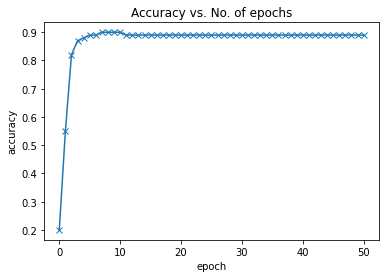

In [88]:
history = history + history1 + history2
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [153]:
w = torch.zeros(2,2,requires_grad=True)
b = torch.tensor([[0.,1.]],requires_grad=True)

In [106]:
def smallmodel(inputs,w,b):
    return inputs @ w.t() + b

In [157]:
num_epochs = 100
lamb = 0.01
for epoch in range(num_epochs):
    for inputs,targets in train_dl:
        outputs = smallmodel(inputs,w,b)
        targets = targets.squeeze(1).long()
        loss = F.cross_entropy(outputs, targets)
        loss.backward()
        with torch.no_grad():
            w -= lamb * w.grad #Bear in mind that we should not expand this thing, otherwise we get NoneType error
            b -= lamb * b.grad
            w.grad.zero_()
            b.grad.zero_()
    if (epoch+1) % 10 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch+1, num_epochs, loss.item(),accuracy(outputs,targets)))

Epoch [10/100], Loss: 0.3964, Accuracy: 0.9000
Epoch [20/100], Loss: 0.3904, Accuracy: 0.9200
Epoch [30/100], Loss: 0.3849, Accuracy: 0.9200
Epoch [40/100], Loss: 0.3797, Accuracy: 0.9200
Epoch [50/100], Loss: 0.3748, Accuracy: 0.9100
Epoch [60/100], Loss: 0.3701, Accuracy: 0.9200
Epoch [70/100], Loss: 0.3657, Accuracy: 0.9200
Epoch [80/100], Loss: 0.3616, Accuracy: 0.9200
Epoch [90/100], Loss: 0.3577, Accuracy: 0.9200
Epoch [100/100], Loss: 0.3539, Accuracy: 0.9200


In [158]:
_,preds = torch.max(smallmodel(inputs,w,b),dim = 1)
print(preds)
print(targets)

tensor([0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 0, 1])
tensor([0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 0, 1])
